# Evaluate the Generated Data


In [1]:
# Set CUDA Device Before Operations: Make sure that you set the CUDA device before performing any operations that would require GPU computation.

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize CUDA Context: If you're using an environment where the CUDA context might 
# not be automatically initialized (like in some Jupyter notebook configurations), 
# you can manually initialize it by running a simple CUDA operation before your main computations:

if torch.cuda.is_available():
    _ = torch.rand(1, device='cuda')

### 1. 读取表格数据

In [2]:
# -- coding: utf-8 --
# import synthetic data vault libraries
# !pip install sdv
import os
import pandas as pd
data_pd = pd.read_csv('CDI_Table2.csv')
data_pd.head()

,YearStart,DataSource,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2021,BRFSS,10,ART,ART5_0,CRDPREV,GENDER,GENM
1,2021,BRFSS,36,ART,ART1_3,CRDPREV,RACE,WHT
2,2021,BRFSS,36,TOB,TOB1_3,CRDPREV,RACE,WHT
3,2021,BRFSS,36,ALC,ALC3_0,MEAN,RACE,MRC
4,2021,BRFSS,36,ART,ART1_3,CRDPREV,RACE,BLK


### 2. 理解数据：Auto detect metadata 获取输入表格数据的列类型和特征

This is an example of a JSON file describing a single table.

参考：
- https://docs.sdv.dev/sdv/single-table-data/data-preparation/single-table-metadata-api
- https://docs.sdv.dev/sdv/reference/metadata-spec/single-table-metadata-json

可视化报错：failed to execute WindowsPath(‘dot‘), make sure the Graphviz executables are on
解决：

1. 先卸载　pip uninstall graphviz
2. 安装windows版的 https://graphviz.org/，勾选系统路径，安装到C:\Users\x\anaconda3\Lib\site-packages\Graphviz
3. 最后安装 pip install graphviz

参考：
- https://blog.csdn.net/gj18405655459/article/details/123234866
- https://blog.csdn.net/m0_52118763/article/details/119919644

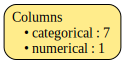

In [3]:
from sdv.metadata import SingleTableMetadata

# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data_pd)
python_dict = metadata.to_dict()
metadata.visualize(
    show_table_details='full',
    output_filepath='my_metadata_full.png'
)
metadata.visualize(
    show_table_details='summarized',
    output_filepath='my_metadata_summarized.png'
)

### 3. 定义评价指标方法

In [4]:
%%writefile SVDevaluation.py
import pandas as pd
import sdv.evaluation.single_table as sdv_st
from sdv.metadata import SingleTableMetadata

# 定义评价指标方法：Column Shapes（FC） 和 Column Pair Trends（FR）
def svd_evaluation(real_data, synthetic_data, savepath, show=False):
    # svd evaluation
    metadata = SingleTableMetadata()  # build a metadata for evaluation (from SDV)
    metadata.detect_from_dataframe(data=real_data)
    quality_report = sdv_st.evaluate_quality(  # generate quality report
        real_data,
        synthetic_data,
        metadata=metadata
    )
    print(quality_report)  # print quality report

    properties_dataframe = quality_report.get_properties()
    Column_Shapes = properties_dataframe.iloc[0, 1]
    Column_Pair_Trends = properties_dataframe.iloc[1, 1]
    print('Column Shapes:', Column_Shapes)
    print('Column Pair Trends:', Column_Pair_Trends)
    properties_dataframe.to_csv(savepath + '_properties_dataframe.csv', index=False)

    if show:
        # plot Column Shapes -> referred to the "Fidelity Column" in the paper
        fig = quality_report.get_visualization(property_name='Column Shapes')
        fig.write_html(savepath + '_Column_Shapes.html')
        fig.show()
        # plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
        fig = quality_report.get_visualization(property_name='Column Pair Trends')
        fig.write_html(savepath + '_Column_Pair_Trends.html')
        fig.show()
    return Column_Shapes, Column_Pair_Trends


if __name__ == '__main__':
    # 假设我们有一些示例的真实数据和合成数据
    # 这里我们只是简单地创建两个包含随机数的DataFrame作为示例
    real_data = pd.DataFrame({
        'A': [1, 2, 3, 4, 5],
        'B': [5, 4, 3, 2, 1],
        'C': [2, 3, 4, 5, 6]
    })

    synthetic_data = pd.DataFrame({
        'A': [1.1, 1.9, 2.8, 4.5, 4.9],
        'B': [5.2, 4.3, 3.4, 2.5, 1.7],
        'C': [2.1, 3.4, 4.5, 5.6, 6.7]
    })

    # 定义一个保存路径
    savepath = "./"

    # 调用 svd_evaluation 函数
    svd_evaluation(real_data, synthetic_data, savepath)


Overwriting SVDevaluation.py


In [5]:
%%writefile Ratio_Difference.py

def ratio_difference(df, samples, savepath=None):
    mean_difference_list = []
    with open(savepath, 'w', encoding='utf-8') as f:
        # 比较每列的分类比例是否与原始设定的比例相同
        for i in range(len(df.columns)):
            column_name = df.columns[i]

            freq_column1 = df[column_name].value_counts(normalize=True).sort_index().tolist()  # 原始数据的频率
            freq_column1_sample = samples[column_name].value_counts(normalize=True).sort_index().tolist()
            # 计算对应元素之间的差并取绝对值
            differences = [abs(x - y) for x, y in zip(freq_column1, freq_column1_sample)]

            # 计算差的均值
            mean_difference = sum(differences) / len(differences)

            # 将打印输出重定向到文件
            print(f"差的均值：{mean_difference}", file=f)
            print(f"{column_name} 原始数据的频率：{freq_column1}", file=f)
            print(f"{column_name} 生成数据的频率：{freq_column1_sample}", file=f)


            print(f"差的均值：{mean_difference}")
            print(f"{column_name} 原始数据的频率：{freq_column1}")
            print(f"{column_name} 生成数据的频率：{freq_column1_sample}")
            mean_difference_list.append(mean_difference)
            
        results = sum(mean_difference_list) / len(mean_difference_list)
        print(f"平均差的均值：{results}", file=f)
        print(f"------------平均差的均值：{results}------------")
    return results

# from Ratio_Difference import ratio_difference
# average_difference = ratio_difference(df, samples, savepath=results_path+'/ratio_difference.txt')

Overwriting Ratio_Difference.py


In [6]:
%%writefile Subclass_Error_Rate.py
import numpy as np
import pandas as pd

# 检查子列中的值是否属于其父列的子类别
def is_subclass_of_parent(row, subclass_col, parent_col, parent_child_mapping):
    subclass_value = row[subclass_col]
    parent_value = row[parent_col]
    valid_children = parent_child_mapping[parent_col].get(parent_value, [])
    return subclass_value in valid_children


def subclass_error_rate(df, subclass_mapping, parent_child_mapping, savepath=None):
    """
    计算DataFrame中的子类别错误率，错误的数量是子列中的值不属于其父列的子类别的数量
    :param df: DataFrame对象
    :param subclass_mapping: 字典，指定子列和父列的对应关系
    :param parent_child_mapping: 字典，父类别和对应的子类别的映射
    :return: 错误率
    """

    error_count = 0  # 错误的总数
    total_pairs = 0  # 检查的子父对总数

    # 遍历所有子父列对
    for subclass_col, parent_col in subclass_mapping.items():
        for index, row in df.iterrows():
            # 检查每一对子父值是否正确
            if not is_subclass_of_parent(row, subclass_col, parent_col, parent_child_mapping):
                error_count += 1  # 错误的子父对数量加1
            total_pairs += 1  # 检查的子父对数量加1

    # 计算错误率
    error_rate = error_count / total_pairs if total_pairs > 0 else 0
    with open(savepath, 'w', encoding='utf-8') as f:
        print(f"----------错误率: {error_rate:.2%}, 错误数量: {error_count}----------", file=f)
    print(f"----------错误率: {error_rate:.2%}, 错误数量: {error_count}----------")
    return error_rate, error_count


if __name__ == '__main__':
    # 定义列之间的子类关系映射
    subclass_mapping = {
        "Column 2": "Column 1",
        "Column 4": "Column 3",
    }
    # 定义父类别和对应的子类别
    parent_child_mapping = {
        "Column 1": {
            "a": ['a1', 'a2', 'a3', 'a4'],
            "b": ["b1", "b2"],
        },
        "Column 3": {
            "c": ['c1', 'c2', 'c3', 'c4'],
            "d": ["d1", "d2"],
        },
    }
    size = 100

    # 生成数据
    column1_data = np.random.choice(list(parent_child_mapping["Column 1"].keys()), size=size)
    column2_data = np.array([parent_child_mapping["Column 1"][c][np.random.randint(0, len(parent_child_mapping["Column 1"][c]))] for c in column1_data])
    column3_data = np.random.choice(list(parent_child_mapping["Column 3"].keys()), size=size)
    column4_data = np.array([parent_child_mapping["Column 3"][c][np.random.randint(0, len(parent_child_mapping["Column 3"][c]))] for c in column3_data])

    # 创建DataFrame
    data = {
        'Column 1': column1_data,
        'Column 2': column2_data,
        'Column 3': column3_data,
        'Column 4': column4_data,
    }
    df = pd.DataFrame(data)

    # 计算并打印错误率
    error_rate, error_count = subclass_error_rate(df, subclass_mapping, parent_child_mapping)
    print(f"错误率: {error_rate:.2%}, 错误数量: {error_count}")

# from Subclass_Error_Rate import subclass_error_rate
# error_rate, error_count = subclass_error_rate(samples, subclass_mapping, parent_child_mapping, savepath=results_path+'/subclass_error_rate.txt')

Overwriting Subclass_Error_Rate.py


In [7]:
def evaluation(data_pd, synthetic_data, result_path):
    # FC: Fidelity Column  FR: Fidelity Row 
    from SVDevaluation import svd_evaluation
    Column_Shapes, Column_Pair_Trends = svd_evaluation(real_data=data_pd, synthetic_data=synthetic_data, savepath=result_path + 'svd_evaluation', show=True)

    # CPD: the category proportion discrepancy
    from Ratio_Difference import ratio_difference
    average_difference = ratio_difference(df=data_pd, samples=synthetic_data, savepath=result_path+'/ratio_difference.txt')

    # ER: Error Rate   EC: Errow Count
    from Subclass_Error_Rate import subclass_error_rate
    import json
    data_path='CDI_Table2.csv'
    with open(data_path.replace('.csv', '_subclass_mapping.json')) as f:
        subclass_mapping = json.load(f)
    with open(data_path.replace('.csv', '_parent_child_mapping.json')) as f:
        parent_child_mapping = json.load(f)
    error_rate, error_count = subclass_error_rate(synthetic_data, subclass_mapping, parent_child_mapping, savepath=result_path+'/subclass_error_rate.txt')

    print("| 列比例差异均值  | fidelity Column | fidelity row  |    错误分类率 |   错误数量 |")
    print(" |------ |------ |------ |------ |-------------- |")
    print(f"| {average_difference:.4f} | {Column_Shapes:.4f} | {Column_Pair_Trends:.4f} | {error_rate:.4f} | {error_count} |")


1. ParentChildEncoder 会把字符串变成数值型，用于生成（编码方式有三种Intern， Entire， ParentChild）
2. 读取转换后的表格（全是数值+label）
3. 数据生成
4. 逆转换回字符串表格

###  4. 使用特定合成器，合成新的数据

In [8]:
# metadata.save_to_json(filepath='CDI_metadata.json')

#-----------------------------------------------Gaussian Copula Synthesizer------------------------------------------------------------#
result_path = 'Gaussian/'
os.makedirs(result_path, exist_ok=True)


from sdv.single_table import GaussianCopulaSynthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(data_pd)
synthetic_data = synthesizer.sample(num_rows=data_pd.shape[0])
synthetic_data.to_csv('Gaussian/samples.csv', index=False)

C:\Users\x\anaconda3\envs\pytorch230\Lib\site-packages\sdv\single_table\base.py:86: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


5. 评价合成数据

In [9]:
evaluation(data_pd, synthetic_data, result_path)

Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 62.15it/s]|
Column Shapes Score: 98.92%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████| 28/28 [00:00<00:00, 37.16it/s]|
Column Pair Trends Score: 90.21%

Overall Score (Average): 94.57%

Column Shapes: 0.989235470579108
Column Pair Trends: 0.9021072801653117


差的均值：0.0
YearStart 原始数据的频率：[1.0]
YearStart 生成数据的频率：[1.0]
差的均值：0.00014941755886189423
DataSource 原始数据的频率：[0.0009482268158543523, 0.0027929589848800923, 0.9915866420702377, 0.0009482268158543523, 0.0009309863282933641, 0.0027929589848800923]
DataSource 生成数据的频率：[0.0009482268158543523, 0.003068806785855904, 0.991190110856335, 0.00106891022878127, 0.0008792648656103995, 0.002844680447563057]
差的均值：0.0028293207404632677
LocationID 原始数据的频率：[0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.01839560022

# 另一个方法结果

In [10]:
#-----------------------------------------------CTGAN Synthesizer------------------------------------------------------------#
result_path = 'CTGAN/'
os.makedirs(result_path, exist_ok=True)
from sdv.single_table import CTGANSynthesizer
synthesizer = CTGANSynthesizer(metadata, epochs=1)
synthesizer.fit(data_pd)
synthetic_data = synthesizer.sample(num_rows=data_pd.shape[0])
synthetic_data.to_csv('CTGAN/samples.csv', index=False)


C:\Users\x\anaconda3\envs\pytorch230\Lib\site-packages\torch\autograd\graph.py:744: UserWarning:

Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)



In [11]:
evaluation(data_pd, synthetic_data, result_path)

Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 84.81it/s]|
Column Shapes Score: 84.21%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.57it/s]|
Column Pair Trends Score: 69.99%

Overall Score (Average): 77.1%

Column Shapes: 0.8421223902211954
Column Pair Trends: 0.6999360870496847


差的均值：0.0
YearStart 原始数据的频率：[1.0]
YearStart 生成数据的频率：[1.0]
差的均值：0.04364716767523518
DataSource 原始数据的频率：[0.0009482268158543523, 0.0027929589848800923, 0.9915866420702377, 0.0009482268158543523, 0.0009309863282933641, 0.0027929589848800923]
DataSource 生成数据的频率：[0.024136682585383516, 0.03641190972880713, 0.8606451390445322, 0.024550454286847233, 0.023257417719773115, 0.030998396634656828]
差的均值：0.007531898820280455
LocationID 原始数据的频率：[0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.0183956002275744

In [12]:
#-------------------------------------------------TVAE Synthesizer-----------------------------------------------------------#
result_path = 'TVAE/'
os.makedirs(result_path, exist_ok=True)
from sdv.single_table import TVAESynthesizer
synthesizer = TVAESynthesizer(metadata, epochs=1)

synthesizer.fit(data_pd)
synthetic_data = synthesizer.sample(num_rows=data_pd.shape[0])
synthetic_data.to_csv('TVAE/samples.csv', index=False)


In [13]:
evaluation(data_pd, synthetic_data, result_path)

Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 61.30it/s]|
Column Shapes Score: 65.5%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████| 28/28 [00:01<00:00, 21.29it/s]|
Column Pair Trends Score: 40.94%

Overall Score (Average): 53.22%

Column Shapes: 0.6550329293312416
Column Pair Trends: 0.40944618628100515


差的均值：0.0
YearStart 原始数据的频率：[1.0]
YearStart 生成数据的频率：[1.0]
差的均值：0.9990517731841456
DataSource 原始数据的频率：[0.0009482268158543523, 0.0027929589848800923, 0.9915866420702377, 0.0009482268158543523, 0.0009309863282933641, 0.0027929589848800923]
DataSource 生成数据的频率：[1.0]
差的均值：0.02032266452087102
LocationID 原始数据的频率：[0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.018395600227574437, 0.0183956002

In [14]:
#-------------------------------------------------只有生成数据的结果 ：NIM----------------------------------------------------------#
# result_path = 'NIM/'
# synthetic_data = pd.read_csv('NIM/samples.csv')
# # fidelity evaluation
# from SVDevaluation import svd_evaluation
# Column_Shapes, Column_Pair_Trends = svd_evaluation(real_data=data_pd, synthetic_data=synthetic_data, savepath=result_path + 'svd_evaluation', show=True)


In [15]:
#-------------------------------------------------Our-----------------------------------------------------------#
# result_path = 'Our/'
# synthetic_data = pd.read_csv('Our/samples.csv')
# # fidelity evaluation
# from SVDevaluation import svd_evaluation
# Column_Shapes, Column_Pair_Trends = svd_evaluation(real_data=data_pd, synthetic_data=synthetic_data, savepath=result_path + 'svd_evaluation', show=True)
